In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import tensorflow as tf
from tensorflow.python.keras import layers
import tensorflow_probability as tfp
from tensorflow.python.keras.callbacks import Callback
from sklearn.model_selection import train_test_split


import functions.parse_data as parse
import functions.models as md
import functions.handy_functions as hf

from keras.utils import plot_model
from IPython.display import Image

from tensorflow_probability import layers as tfpl



In [2]:

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])

## Train 5 layer model with 64 neurons per hidden layer.

In [37]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle','COT','Cloud_Type','Profile_ID','GOT','Water_Vapor']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.

y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)
num_epochs=2
batch_size=100
model, history_df, X_test,y_test=md.train_5layer_64neurons_model(df,x_labels=X_labels,y_labels=y_labels,split=[0.6,0.2,0.2],epochs=num_epochs,batch_size=batch_size)

Epoch 1/2
1280/1280 [==============================] - 41s 32ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 2/2
1280/1280 [==============================] - 41s 32ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0054 - val_mse: 0.0054


In [38]:
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=2)
print(f"Test mse: {test_mse}")

1250/1250 - 9s - loss: 0.0054 - mse: 0.0054 - 9s/epoch - 8ms/step
Test mse: 0.005432151257991791


In [39]:
y_predict=model.predict(X_test)

1250/1250 [==============================] - 5s 4ms/step


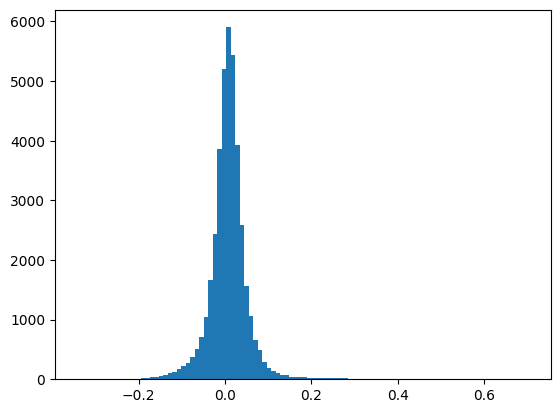

In [40]:
y_test_np=y_test.to_numpy()
channel=6
plt.hist(y_predict[:,channel]-y_test_np[:,channel],bins=100)
plt.show()

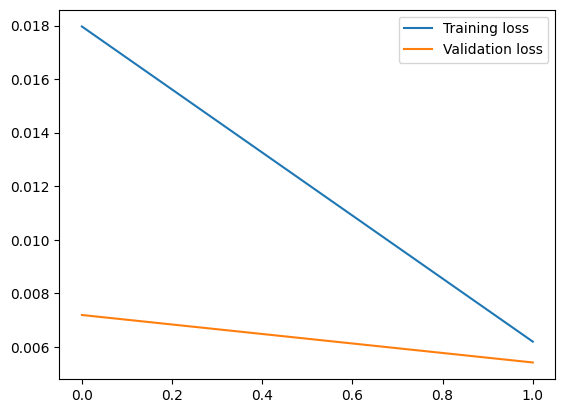

In [41]:
plt.plot(history_df['training_loss'])
plt.plot(history_df['validation_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.show()

## Train a first bayesian network

In [3]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle','COT','Cloud_Type','Profile_ID','GOT','Water_Vapor']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.

y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)
num_epochs=2
batch_size=100
model, history_df, X_test,y_test=md.train_first_bayesian_model(df,x_labels=X_labels,y_labels=y_labels,split=[0.6,0.2,0.2],epochs=num_epochs,batch_size=batch_size)



Epoch 1/2

1280/1280 [==============================] - 98s 76ms/step - loss: 28.8945 - mse: 1.1502 - val_loss: 6.5572 - val_mse: 1.1050
Epoch 2/2
1280/1280 [==============================] - 88s 69ms/step - loss: 3.4171 - mse: 1.1908 - val_loss: 2.2405 - val_mse: 1.2096


In [4]:
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=2)
print(f"Test mse: {test_mse}")

1250/1250 - 27s - loss: 2.0188 - mse: 1.2093 - 27s/epoch - 22ms/step
Test mse: 1.2093077898025513


In [5]:
y_predict=model.predict(X_test)

1250/1250 [==============================] - 26s 21ms/step


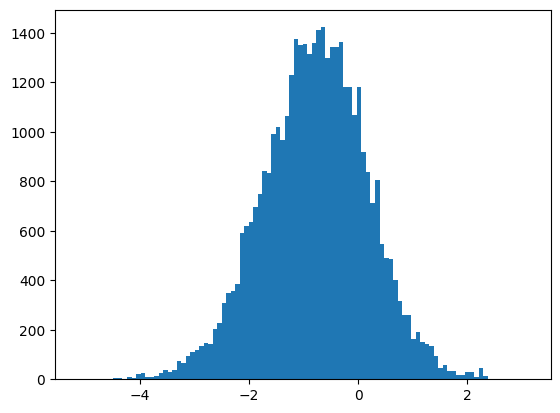

In [6]:
y_test_np=y_test.to_numpy()
channel=5
plt.hist(y_predict[:,channel]-y_test_np[:,channel],bins=100)
plt.show()

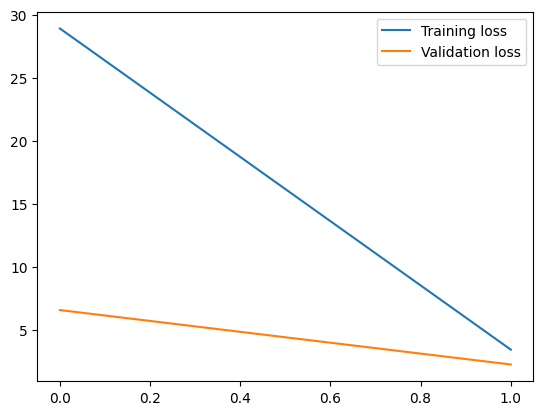

In [7]:
plt.plot(history_df['training_loss'])
plt.plot(history_df['validation_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.show()

In [8]:
history_df['posterior_mean']

0    [0.07313041, 0.054164495, 0.045236353, 0.07457...
1    [0.036100447, 0.06549051, 0.14346719, 0.119499...
Name: posterior_mean, dtype: object

In [9]:
len(model.layers[-1].get_weights()[0])

1560

In [10]:
dummy_input = np.array([[0]])
model_prior = model.layers[-1]._prior(dummy_input)
model_posterior = model.layers[-1]._posterior(dummy_input)

print('Prior mean:     ', model_prior.mean().numpy())
print('Prior Variance: ', model_prior.variance().numpy())
print('Posterior mean: ', model_posterior.mean().numpy())
print('Posterior variance:', model_posterior.variance().numpy()[0])

Prior mean:      [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [11]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_plot.png')
Image('model_plot.png')

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [52]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_plot.png')

AttributeError: module 'pydot' has no attribute 'InvocationException'